In [1]:
from  astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
import glob
from datetime import datetime
from specutils import Spectrum1D, SpectralRegion
from specutils.analysis import correlation
from astropy.modeling import models
import astropy.units as u
import matplotlib.ticker as ticker
from specutils.manipulation import extract_region
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator

calib/tlvnrs04-fa18-20250512-0018-e92-1d.fits.fz -> dateobs: 2025-05-13 00:04:50.990000   rv: -115936.945m/s barycorr:  -6509.850m/s


<Figure size 640x480 with 0 Axes>

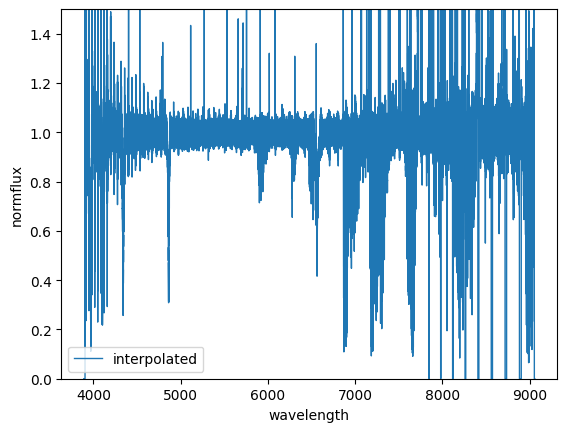

<Figure size 640x480 with 0 Axes>

In [2]:
### Organize a sequence of NRES spectras into a dict:
# dict['filenmame'] = {'wavelength': wavelength, 'normflux': normflux, 'dataobs': dataobs}

spectrumdata = {}

def interpolate_nres_spectrum (filename, plot = False, barycorrect = False, writetoascii = False, interpoltype='linear'):
    """
    Read a NRES spectrum from a file.
    
    Parameters
    ----------
    filename : str
        The name of the file to read.
    barycorrect : bool, optional
        If True, apply barycentric correction to the wavelength. Default is False.
    
      Returns a flattened out spectrum with one wavelength and one normflux array.
    -------
    """

    with fits.open(filename) as hdu:  
      data = hdu["SPECTRUM"].data
      data = data[data['fiber']!=1]   # Anything but the ThAr fiber.
      wavelength = data['wavelength']
      normflux = data['normflux']
      flux = data['flux']
      mask = data['mask']
      blaze = data['blaze']
      normuncertainty = data['normuncertainty']
      order = data['order']

      # Get some meta data from the FITS headers
      exptime = hdu[0].header['EXPTIME']
      dateobs = hdu[0].header['DATE-OBS']
      mjd = hdu[0].header['MJD-OBS']
      object = hdu[0].header['OBJECT']
      dateobs = datetime.strptime(dateobs, '%Y-%m-%dT%H:%M:%S.%f')

      rv = hdu[0].header['RV']
      rverr = hdu[0].header['RVERR']
      barrycorr = hdu[0].header['BARYCORR']
      print (f"{filename} -> dateobs: {dateobs}   rv: {rv: 8.3f}m/s barycorr: {barrycorr: 10.3f}m/s")

      # R~=45000 -> resolved element is of roder of 4000A/45000 = 0.088A
      # we choose a resolution of 0.02A for the grid.
      # The grid is 3890A to 9060A, which is the range of the NRES spectrograph.
      grid_wavelength = np.arange(3890, 9060, 0.02) # todo: fine tune for actual min / max
      grid_normflux = grid_wavelength * 0.
      grid_flux = grid_wavelength * 0.

      for  ii, myorder  in enumerate(order):       
        wavelength_order = wavelength[ii] 
        normflux_order = np.asarray(normflux[ii])
        flux_order = flux[ii]
        mask_order = mask[ii]
        normuncertainty_order = normuncertainty[ii]
       
        good = (normflux_order>0.05) &  (wavelength_order > 0) & (wavelength_order < 10000) & (normflux_order < 10000)
        if np.sum(good) >0:
          wavelength_order = wavelength_order[good]
          normflux_order = normflux_order[good]
          flux_order = flux_order[good]
          model_normflux = interp1d(wavelength_order, normflux_order, kind=interpoltype, bounds_error=False)
          model_flux = interp1d(wavelength_order, flux_order, kind=interpoltype, bounds_error=False)
  
          min_lambda = np.min(wavelength_order)
          max_lambda = np.max(wavelength_order)
          firstindex = np.argmax(grid_wavelength>=min_lambda) 
          # Fill in the interpolated spectrum grid with actual values from the orders. 
          # TODO: When there is data from several orders, mix them or use the higher S/N signal.
          while ( (firstindex < len(grid_normflux)) & (grid_wavelength[firstindex] < max_lambda)):
            
            interpolated_value = model_normflux(grid_wavelength[firstindex])
            gridvalue = grid_normflux[firstindex]
            grid_normflux[firstindex] = interpolated_value  if gridvalue == 0 else  gridvalue
            
            firstindex += 1
          
    if barycorrect:
      vc = barrycorr / 2.998e+8
      grid_wavelength = grid_wavelength * (1 -vc / (1+vc)) # validate formual!

    if plot:
      fig, ax = plt.subplots()       
      ax.plot(grid_wavelength, grid_normflux, linewidth=1, label=f"interpolated")     
      ax.set_ylabel("normflux")
      ax.set_xlabel("wavelength")
      plt.ylim(0, 1.5)
      plt.legend()
      hdu.close()
      plt.savefig(f"nres_spectrum{dateobs}.pdf", dpi=300)
    
    if writetoascii:
      spec1d = Spectrum1D(spectral_axis=grid_wavelength*u.AA, flux=grid_normflux * u.adu )
      spec1d.write(f"nres_spectrum_{object}_{dateobs}.fits", overwrite=True)
    
    returndict = {'dateobs':dateobs, 
                  'mjd': mjd,
                  'wavelength': grid_wavelength, 
                  'normflux':grid_normflux,
                  'banzai_rv': rv,
                  'banzai_rverr': rverr,
                  'barycorr': barrycorr,}
    
    return (returndict)

singlespectrum = interpolate_nres_spectrum("calib/tlvnrs04-fa18-20250512-0018-e92-1d.fits.fz",  writetoascii=True, plot=True,interpoltype='linear')
plt.figure()



In [ ]:
## We read in all the spectra taken of teh target star and put them into a dict.
files = glob.glob("spectra/*-1d.fits.fz")
starname="Beta Dor"
period = 9.84318

#files = glob.glob("DeltaScu/*-1d.fits.fz")
#starname="Delta Scuti"
#period = 0.1937697000	


myspectra = {}
for filename in files:
    dataset = interpolate_nres_spectrum(filename, barycorrect=True, plot=False, writetoascii=False)                                 
    dateobs = dataset['dateobs']
    dataset['filename'] = filename
    myspectra[dateobs] = dataset

spectra/cptnrs03-fa13-20250328-0017-e92-1d.fits.fz -> dateobs: 2025-03-28 19:41:40.409000   rv:  27614.785m/s barycorr:  -1977.453m/s
spectra/lscnrs01-fa09-20250331-0020-e92-1d.fits.fz -> dateobs: 2025-04-01 01:43:28.389000   rv:  1048.756m/s barycorr:  -1877.482m/s
spectra/cptnrs03-fa13-20250406-0017-e92-1d.fits.fz -> dateobs: 2025-04-06 17:46:00.849000   rv:  20800.602m/s barycorr:  -1632.588m/s
spectra/cptnrs03-fa13-20250402-0016-e92-1d.fits.fz -> dateobs: 2025-04-02 18:35:21.593000   rv: -581.180m/s barycorr:  -1790.990m/s
spectra/cptnrs03-fa13-20250401-0019-e92-1d.fits.fz -> dateobs: 2025-04-01 19:14:59.578000   rv:  1758.209m/s barycorr:  -1841.362m/s
spectra/cptnrs03-fa13-20250327-0019-e92-1d.fits.fz -> dateobs: 2025-03-27 19:22:21.366000   rv:  19900.348m/s barycorr:  -1999.557m/s
spectra/cptnrs03-fa13-20250411-0017-e92-1d.fits.fz -> dateobs: 2025-04-11 18:32:47.346000   rv:  1662.788m/s barycorr:  -1481.736m/s
spectra/cptnrs03-fa13-20250326-0016-e92-1d.fits.fz -> dateobs: 2025

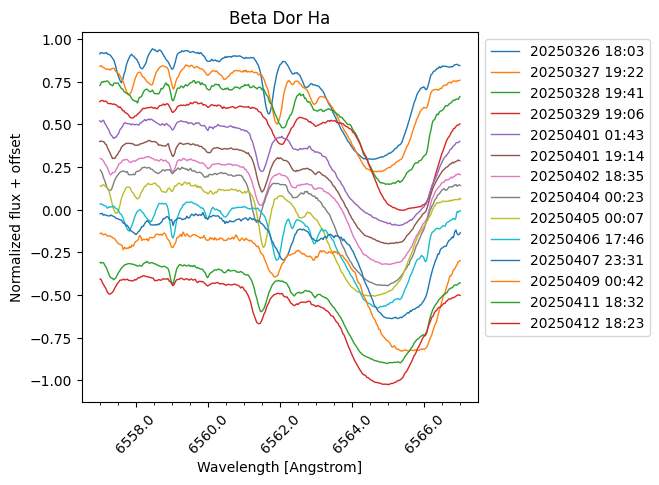

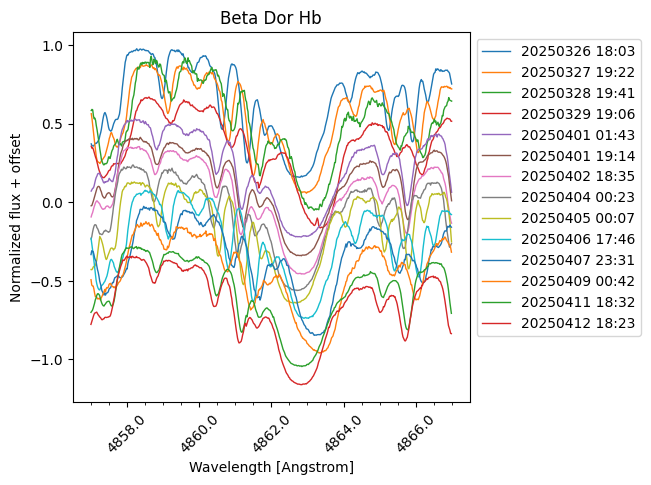

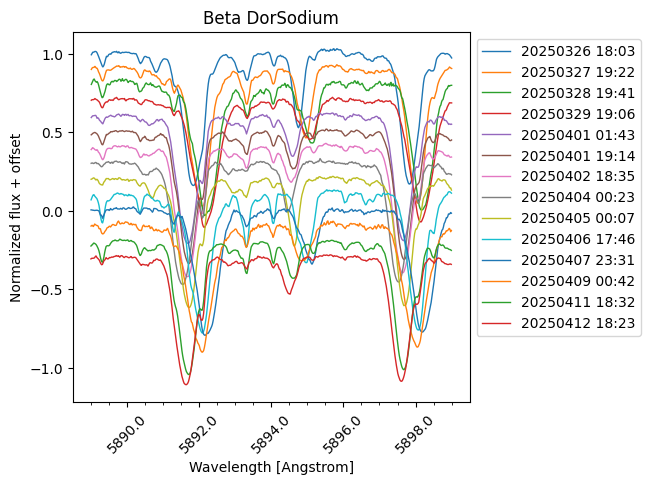

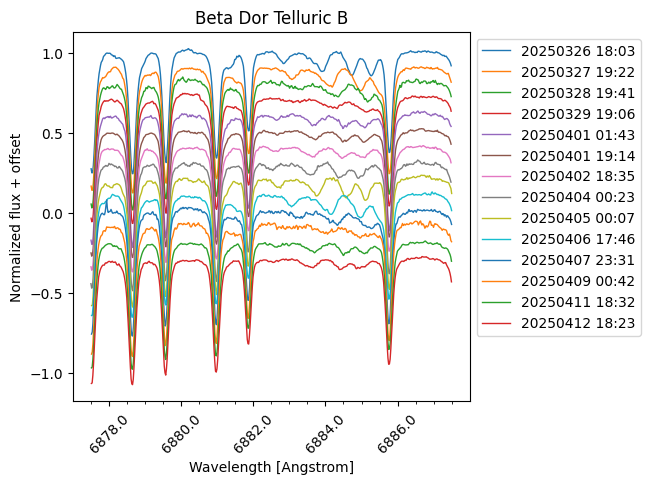

In [4]:
## Here we plot zoomed in spectra arond select absorption lines: H-alpha, H-beta, Sodium D, and telluric lines.
## We order in time, earlier on top, and plot the spectra with an arbritray offset to demontrate the shift in the absorption line position, reflecting 
## the radial velocity of the star.

def simpledateformat ():
    plt.gcf().autofmt_xdate()
    plt.setp(plt.gca().xaxis.get_minorticklabels(), rotation=45)
    plt.setp(plt.gca().xaxis.get_majorticklabels(), rotation=45)
    plt.gca().grid(which='minor')

def plot_single_line (wave, flux,  center_wavelegnth = 6562.8,  wavelength_range = 20, offset = 0, label="H alpha"):
    wavelength_mask = (wave > center_wavelegnth - wavelength_range) & (wave < center_wavelegnth + wavelength_range)
    plt.plot(wave[wavelength_mask], flux[wavelength_mask] + offset, linewidth=1, label=label)

def plot_fullset (dataset, center_wavelegnth = 6562.8, wavelength_range = 20, label="ha",):
    fig, ax = plt.subplots()
    offset = 0
    ordered = sorted(dataset.keys())
    for key in ordered:
      data = dataset[key]
      dateobs = data['dateobs']

      plot_single_line (data['wavelength'], data['normflux'], center_wavelegnth = center_wavelegnth, wavelength_range = wavelength_range, offset = offset, 
                        label=f'{dateobs.strftime("%Y%m%d %H:%M")}')
      offset -= 0.1

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
    plt.setp(plt.gca().xaxis.get_minorticklabels(), rotation=45)
    plt.setp(plt.gca().xaxis.get_majorticklabels(), rotation=45)

    ax.set_ylabel("Normalized flux + offset")
    ax.set_xlabel("Wavelength [Angstrom]")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.savefig(f"nres_spectrum_{label}.pdf", dpi=300)
    ax.set_title(f"{label}")

plot_fullset(myspectra, center_wavelegnth = 6562.0, wavelength_range=5, label=f"{starname} Ha")
plot_fullset(myspectra, center_wavelegnth = 4862.0, wavelength_range=5, label=f"{starname} Hb")
plot_fullset(myspectra, center_wavelegnth = 5894.0, wavelength_range=5, label=f"{starname}Sodium")
plot_fullset(myspectra, center_wavelegnth = 6882.5, wavelength_range=5, label=f"{starname} Telluric B")

Best period: 10.000 days


/var/folders/rr/wl6nqmp921x1mqz575fbfnpc0000gn/T/ipykernel_4700/1840857656.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


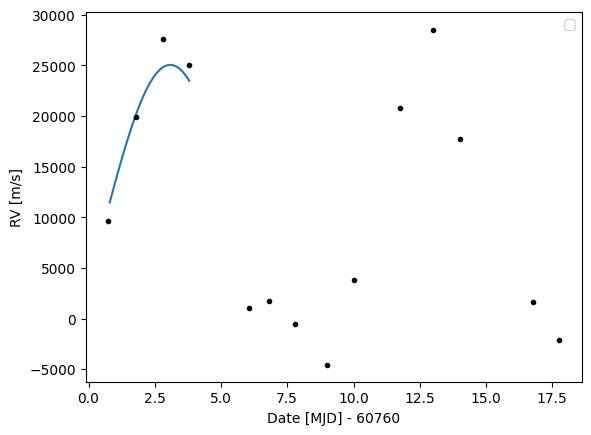

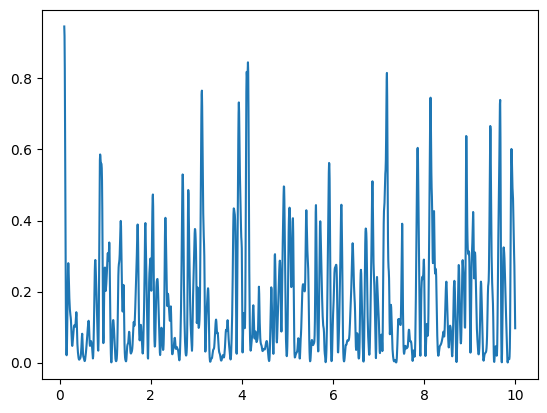

In [5]:
## Banzai derives a a radial velocity from the spectrum. We plot the radial velocity as a function of time, showing the expansion of the star. 
# Be aware that on top of that expansion we have the inrtinsic radial velocity of the star as it moves accross the Galaxy. 
# Banzai derives the radial velocity by cross-correlating the spectrum with a theoretical best-match template spectrum.
import math
from astropy.timeseries import LombScargle

def Plot_rvs(dataset, idx='banzai_rv', err=None):
    fig, ax = plt.subplots()
    ordered = sorted(dataset.keys())
    all_dateobs = []
    all_rv = []
    all_error = []
    all_mjd = []
    
    for key in ordered:
      data = dataset[key]
      
      all_dateobs.append(data['dateobs'])
      all_mjd.append (data['mjd'])
      all_rv.append(data[idx])    
    
      if err:
         all_error.append(data[err])
   
    all_mjd  = np.array(all_mjd)
    all_rv   = np.array(all_rv)
    start_mjd = math.floor(all_mjd[0])
    all_mjd = all_mjd - start_mjd

    if err:
       ax.errorbar(all_mjd, all_rv, yerr=all_error, c='black', fmt='.')
    else:
       ax.plot(all_mjd, all_rv, 'o', c='black', label=idx)

    ax.set_ylabel("RV [m/s]")
    ax.set_xlabel(f"Date [MJD] - {start_mjd:.0f}")
    plt.legend()
    #simpledateformat()

    ls = LombScargle(all_mjd, all_rv, all_error, fit_mean=True, nterms=1)
    frequency, power = ls.autopower( minimum_frequency=0.1, maximum_frequency=10,samples_per_peak=10)
    best_frequency = frequency[np.argmax(power)]
    best_period = 1 / best_frequency
    print (f"Best period: {best_period:.3f} days")
    

    plt.savefig(f"nres_spectrum_rv.pdf", dpi=300)
    t_fit = np.linspace(0.8, 3.8,10000)
    y_fit = ls.model(t_fit, best_frequency)
    plt.plot (t_fit, y_fit)

    fig, ax = plt.subplots()
    plt.plot (frequency, power)
    period = best_period
    
    


    
Plot_rvs(myspectra, idx = 'banzai_rv', err='banzai_rverr')




In [6]:
## We can also derive the radial velocity by autocorrelating the spectrum with itself. 
# We use the first spectrum in the time sequence as the template and cross-correlate around a select region in the spectrum 
# Note that different regions in the spectrum will give different results as they probe different parts of the stars athmosphere. 

def rv_autocorrelate(spectrumset, centralwavelength, delta_lambda, label="corr_rv"):
    """
    Autocorrelate the spectrumset around a given wavelength.
    """
    refidx =  (list(spectrumset.keys())[0])
    referencespectrum = spectrumset[refidx] 
    region = SpectralRegion((centralwavelength-delta_lambda)*u.AA, (centralwavelength + delta_lambda)*u.AA)
    template_spectrum = extract_region(Spectrum1D(flux=referencespectrum['normflux']*u.photon/u.second, spectral_axis=referencespectrum['wavelength'] * u.AA, velocity_convention='optical'), region)
  
    autocorr = {}
    for key in spectrumset.keys():
        spectrum = extract_region(Spectrum1D(flux=spectrumset[key]['normflux'] * u.photon/u.second, spectral_axis=spectrumset[key]['wavelength'] * u.AA, velocity_convention='optical'), region)
        corr, lag = correlation.template_correlate(spectrum, template_spectrum, resample=False)
        maxind = np.argmax(corr)
        spectrumset[key][label] = lag[maxind].value * 1000
    
    return autocorr

# rv_autocorrelate(myspectra, 6562, 10, label='rv_Ha')
# Plot_rvs(myspectra, idx='rv_Ha')
# rv_autocorrelate(myspectra, 4862, 10, label='rv_Hb')
# Plot_rvs(myspectra, idx='rv_Hb')
# rv_autocorrelate(myspectra, 5894, 10, label='rv_NaD')
# Plot_rvs(myspectra, idx='rv_NaD')
# rv_autocorrelate(myspectra, 6882.5, 10, label='rv_Telluric')
# Plot_rvs(myspectra, idx='rv_Telluric')

Mean RV: 8900.889980676184  m/s
Roots: [-0.93122565 -0.51926505  0.06877435  0.48073495]
Radial Expansion: [ 5.88468562 -5.88468562  5.88468562]  R_sun


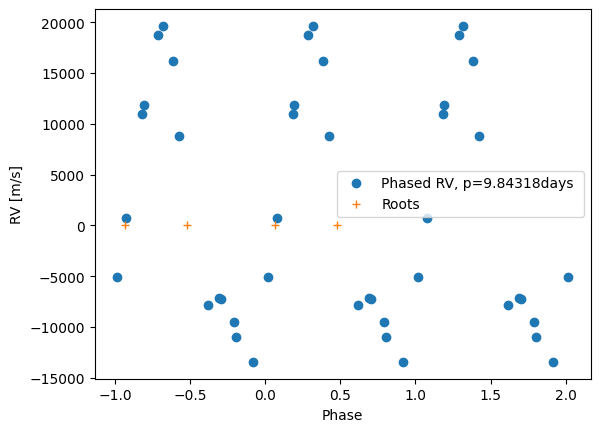

In [7]:
## Now we want to phase the RV curve, as we observed over several periods. 
## While we are at it, we (i) find the radial velocity by finding the mean rv (via interal of RV over time of a single period,
## and also integrate over the expanding and deflating phase to find out by how much the star actually expands. 

def make_phased_rv(dataset, period=9.84318):
    ordered = sorted(dataset.keys())
    startjd = ordered[0]
    for key in dataset.keys():      
        deltaT = dataset[key]['mjd'] - math.floor(dataset[startjd]['mjd'])
        deltaT = deltaT 
        phase = deltaT % period / period
        dataset[key]['phase'] = phase

def plot_phased_lightcurve (dataset, rv_index, period=None):
    fig, ax = plt.subplots()
    phases = []
    rvs = []
    for keys in dataset.keys():
        data = dataset[keys]
        phases.append(data['phase'])
        rvs.append (data[rv_index])

    phases = np.asarray(phases)
    rvs = np.asarray(rvs)
    tphases = np.append(phases, phases+1)
    tphases = np.append (tphases, phases-1)
    
    trvs = np.append (rvs, rvs)
    trvs = np.append (trvs, rvs)
   
    p = np.argsort(tphases)
    tphases = tphases[p]
    trvs = trvs[p]
    tphases = np.append (tphases, tphases[0]+3)
    trvs = np.append (trvs, trvs[0])
       
    model = CubicSpline(tphases, trvs, bc_type='periodic')
    model_base = np.arange(-1,2,0.01)
    meanrv =  model.integrate(0,1)
    print ("Mean RV:", meanrv, " m/s")

    trvs = trvs - meanrv

    model = CubicSpline(tphases, trvs, bc_type='periodic')
    model_values = model(model_base)
 
    ax.plot(tphases, trvs, 'o', label=f'Phased RV, p={period}days ')
    #ax.plot (model_base, model_values, label='Interpolated')
   
    roots = model.roots()
    roots = roots[(roots >-1) & (roots < 1)]
    print ("Roots:", roots)
    ax.plot(roots, model(roots), '+', label='Roots')
    

    integrals = []
    for i in range(len(roots)-1):
        integrals.append(model.integrate(roots[i], roots[i+1]))
       
    # unit of integral is m/s * phase.
    solar_radius = 6.957e+8
    # To get km, we wantto ultiply with period * 24*3600  / solar_radius
    integrals = np.asarray(integrals) * period * 24*3600 / solar_radius
    print ("Radial Expansion:", integrals, " R_sun")

    plt.legend()
    ax.set_ylabel("RV [m/s]")
    ax.set_xlabel("Phase")
    plt.savefig(f"nres_spectrum_phased_{rv_index}.pdf", dpi=300)

make_phased_rv(myspectra, period=period)
plot_phased_lightcurve(myspectra, rv_index='banzai_rv', period=period)
#plot_phased_lightcurve(myspectra, rv_index='rv_feI', period=period)
#plot_phased_lightcurve(myspectra, rv_index='rv_Ha', period=period)

27614.78546620921 30723.941588269816
1048.7564015342505 4963.50110795692
20800.60228459562 23878.63502400761
-581.1801463274879 3154.752867881767
1758.2093223854135 5628.7814493819205
19900.3481275792 23916.93449208311
1662.7876827081473 4728.9669319750365
9628.45626166989 13772.128429995593
-2132.087225652459 966.636704846667
25068.028965643327 28136.17845043237
-4541.734690299425 -607.7343180716085
3847.8240158657068 7445.951586723462
28538.35317787124 31028.60841690843
17714.17518384943 20922.91754834146


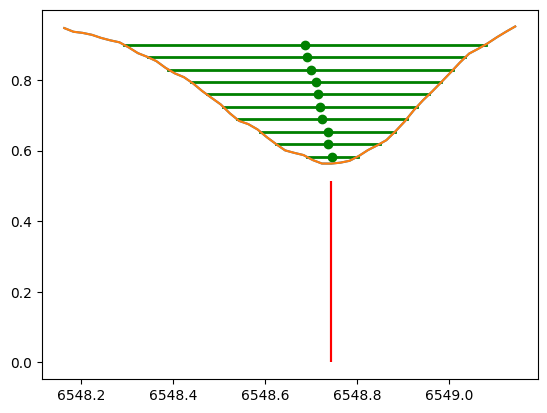

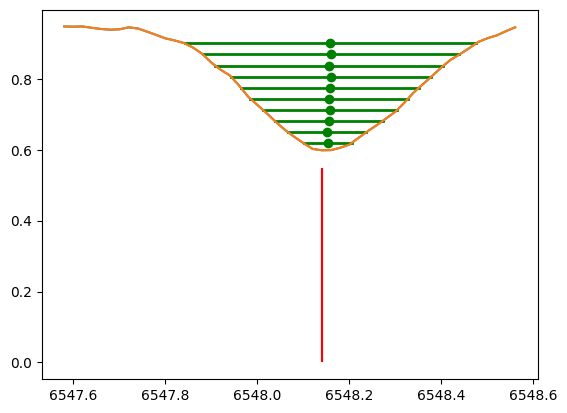

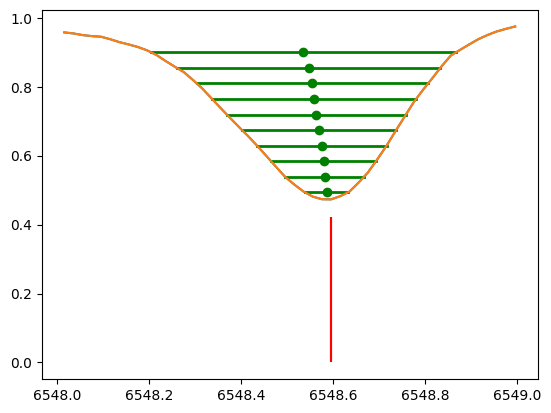

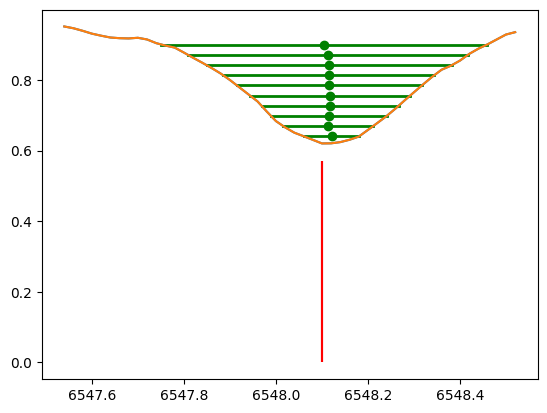

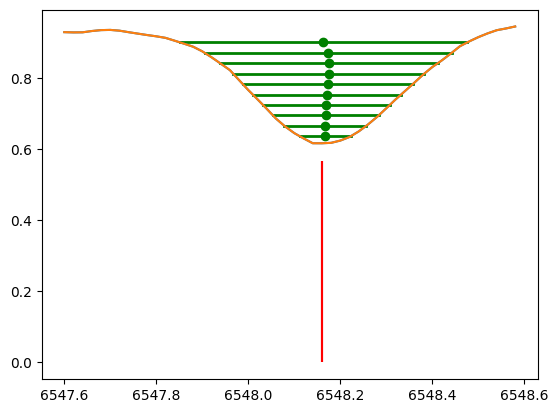

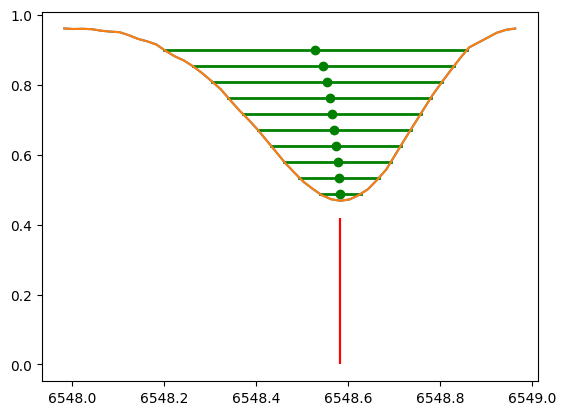

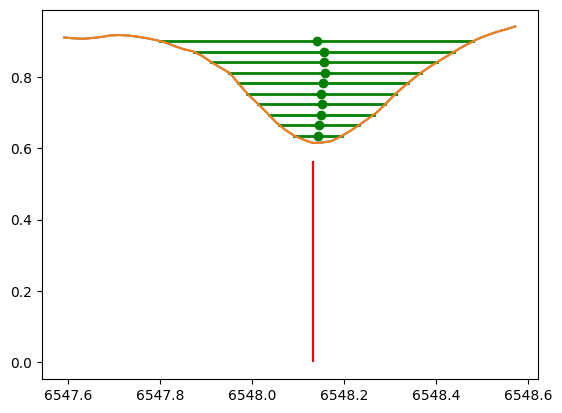

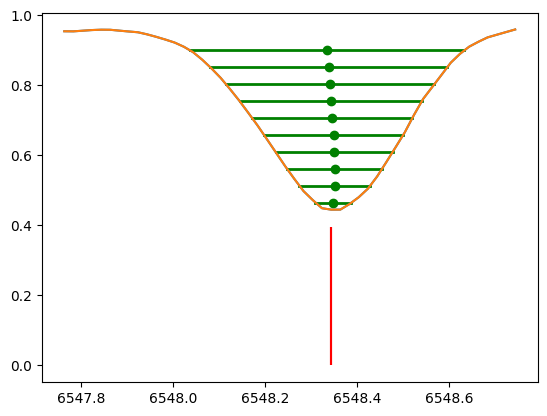

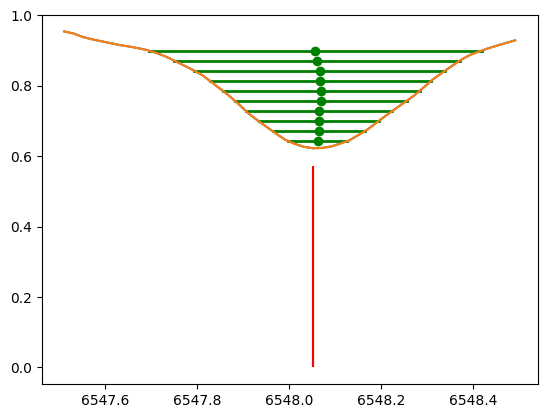

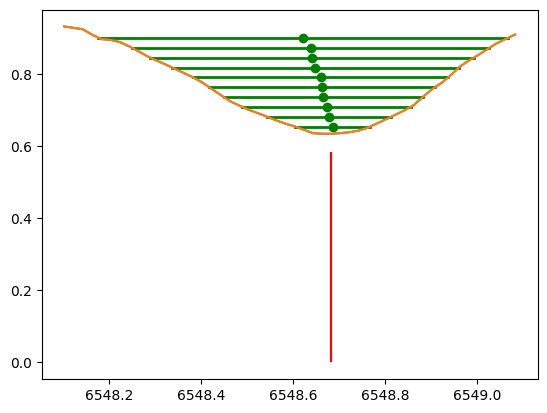

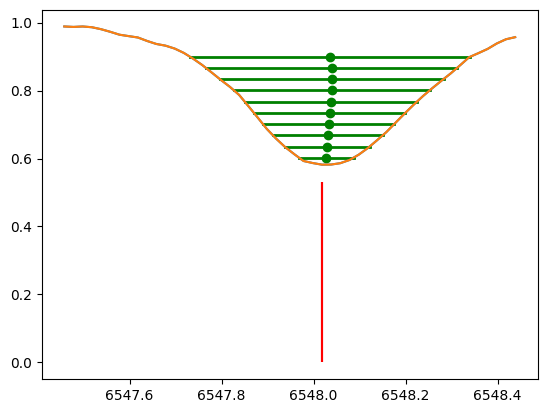

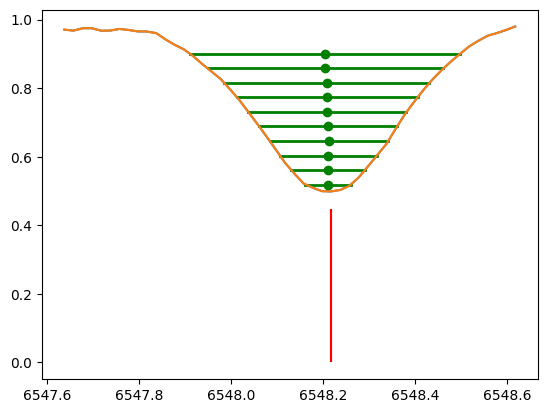

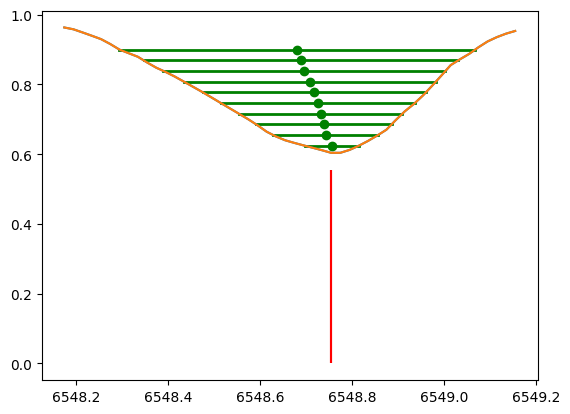

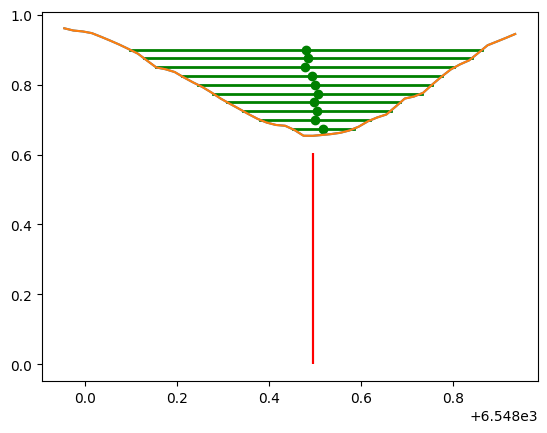

In [8]:
def air_to_vacuum_wavelength(wavelength_air):
    """
    Convert air wavelength to vacuum wavelength using the IAU standard formula.

    Parameters
    ----------
    wavelength_air : float or array-like
        Wavelength in air (in Angstrom).

    Returns
    -------
    wavelength_vacuum : float or array-like
        Wavelength in vacuum (in Angstrom).
    """
    sigma2 = (1e4 / wavelength_air)**2  # Convert wavelength to wavenumber squared
    factor = 1 + 0.0000834254 + 0.02406147 / (130 - sigma2) + 0.00015998 / (38.9 - sigma2)
    wavelength_vacuum = wavelength_air * factor
    return wavelength_vacuum

def calculate_bisector_velocity_span(wavelength, normflux, rv_estimate, central_wavelength, num_depths=10, initialsearchwidth=0.5, plot=False):
    """
    Calculate the bisector velocity span for an absorption line.

    Parameters
    ----------
    wavelength : array
        The wavelength array of the spectrum.
    normflux : array
        The normalized flux of the spectrum.
    rv_estimate : float
        Preliminary radial velocity estimate (in m/s).
    central_wavelength : float
        Central wavelength of the absorption line (in Angstrom).
    num_depths : int, optional
        Number of absorption depths to calculate the velocity span, by default 10.

    Returns
    -------
    depths : array
        Array of absorption depths.
    bisector_centers : array
        Estimated center of the absorption line at each depth.
    """
    # Adjust the central wavelength for the radial velocity
    c = 299792.458  # Speed of light in km/s
    adjusted_central_wavelength = central_wavelength * (1 + rv_estimate / c / 1000)

    # Mask the region around the absorption line
    mask = (wavelength > adjusted_central_wavelength - initialsearchwidth) & (wavelength < adjusted_central_wavelength + initialsearchwidth)
    masked_wavelength = wavelength[mask]
    masked_flux = normflux[mask]

    absorption_center_idx = np.argmin(masked_flux)
    absorption_center_flux = masked_flux[absorption_center_idx]
    absorprion_center_wavelength = masked_wavelength[absorption_center_idx]

  

    # Define absorption depths
    depths = np.linspace(absorption_center_flux+0.02, 0.9, num_depths)
    bisector_centers = []

    for depth in depths:
        # Find the wavelength range corresponding to the given depth
       
        interpolator = CubicSpline(masked_wavelength, masked_flux - depth, bc_type='natural')
        roots = interpolator.roots()
        roots = roots
        if len(roots) >2:
            closestidx = np.argsort(np.abs(roots - adjusted_central_wavelength))
            roots = roots[closestidx[:2]]           
          
        if len(roots) == 2:          
            left_lambda = roots[0]
            right_lambda = roots[1]
            bisector_center = (left_lambda + right_lambda) / 2
            bisector_centers.append(bisector_center)
            if plot:
                plt.plot ([left_lambda, right_lambda], [depth, depth], color='green', linewidth=2)
                plt.plot (bisector_center, depth, 'o', color='green')
        else:
            print ("To many roots found:", roots)


    if plot:
        plt.plot (masked_wavelength, masked_flux, label='Spectrum')
        plt.vlines(absorprion_center_wavelength, 0,  absorption_center_flux-0.05, color='red', label='Central Wavelength')
        plt.plot (masked_wavelength, masked_flux, label='Spectrum')
        plt.vlines(absorprion_center_wavelength, 0,  absorption_center_flux-0.05, color='red', label='Central Wavelength')
    wavelengthshift = bisector_centers[4] - central_wavelength
    radialvelocity = wavelengthshift / central_wavelength * c * 1000
    return radialvelocity
    


for idx in myspectra.keys():
    singlespectrum = myspectra[idx]
    # Calculate bisector velocity span
    plt.figure()
    feIrv = calculate_bisector_velocity_span(singlespectrum['wavelength'], singlespectrum['normflux'], singlespectrum['banzai_rv'], air_to_vacuum_wavelength(6546.2395), num_depths=10, plot=True)
    #feIrv = calculate_bisector_velocity_span(singlespectrum['wavelength'], singlespectrum['normflux'], singlespectrum['banzai_rv'],656.46, num_depths=10, plot=True)

    singlespectrum['rv_feI'] = feIrv
    print (singlespectrum['banzai_rv'],singlespectrum['rv_feI'])
    



#plt.figure()
#calculate_bisector_velocity_span(singlespectrum['wavelength'], singlespectrum['normflux'], singlespectrum['banzai_rv'],  6564.6, num_depths=10)